# A/B тест: Влияние исламского праздника на продажу шоколадок

<div style="border:solid blue 2px; padding: 20px">
    
**Цель проекта:**
Проверить гипотезу о том, что продажи в регионах Татарстан и Башкортостан значительно увеличились в период религиозного праздника Ураза-байрам, в отличие от остальных регионов России, где подобного эффекта не наблюдается.

**Контекст и предпосылка:**
В рамках проекта необходимо было оценить влияние конкретного временного события (религиозный праздник) на продажи FMCG-товаров. Основное предположение:

*"В релевантных регионах (Татарстан и Башкортостан) продажи увеличиваются в период праздника, тогда как в контрольных — нет."*


<div style="border:solid green 2px; padding: 20px">
    
**Справка о празднике**

Ураза-байрам - отмечают в исламе как праздник разговения, который символизирует окончание месяца Рамадан.

Особенность - на прямую прадник и празднование Уразы-байрам не связано с категорией шоколадок и конфет

Период до праздника: с 5 по 8 неделю 
Период праздника: с 9 по 12 неделю

<div style="border:solid blue 2px; padding: 20px">
    
**Данные**

Объемы продаж за 4 недели до праздника и за 4 недели в период праздника Ураза.

- *Product Code* - уникальный код продукта
- *Technology* - технология / тип продукта
- *YearWeek* - год и неделя продаж
- *Turnover Qty* - объем продаж
- *Outlet Region* - регион продаж


**Методология**
1. Загрузка и обработка данных
2. Предварительный анализ и описание данных
3. Разделение выборок на тестовую и контрольную
4. Разделение тестовой и контрольной выборки по веремени (4 недели до праздника и 4 недели периода праздника
5. Метод сравнения:
   - Использован метод "разницы разностей" (Difference-in-Differences, DiD) для учёта временных трендов и сезонности.
   - Для проверки статистической значимости применён бутстрэпинг (bootstrap resampling) с вычислением доверительного интервала разницы.
6. Ключевая метрика: Объём продаж (Turnover Qty) по регионам и неделям.

## Загрузка и очистка данных

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
from matplotlib.ticker import FuncFormatter

In [13]:
data = pd.read_excel(r'C:\Users\ASUS\Downloads\Uraza.xlsx')

In [14]:
data = data.drop(columns = 'Product') 

In [15]:
data.head(5)

,Product Code,Technology,YearWeek,Turnover Qty,Outlet Region
0,15205,Sticks,2025-05,15.0,Курганская область
1,15205,Sticks,2025-05,24.0,Нижегородская область
2,15205,Sticks,2025-05,4.0,Оренбургская область
3,15205,Sticks,2025-05,4.0,Пермский край
4,15205,Sticks,2025-05,15.0,Республика Башкортостан


In [16]:
data.describe(include='all')

,Product Code,Technology,YearWeek,Turnover Qty,Outlet Region
count,8106,8104,8104,5.487000e+03,8104
unique,235,22,8,NaN,12
top,15205,Bars,2025-10,NaN,Нижегородская область
freq,96,1564,1341,NaN,1119
mean,NaN,NaN,NaN,5.766023e+03,NaN
std,NaN,NaN,NaN,1.360500e+05,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.000000e+01,NaN
50%,NaN,NaN,NaN,6.957800e+02,NaN
75%,NaN,NaN,NaN,5.036000e+03,NaN


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Code   8106 non-null   object 
 1   Technology     8104 non-null   object 
 2   YearWeek       8104 non-null   object 
 3   Turnover Qty   5487 non-null   float64
 4   Outlet Region  8104 non-null   object 
dtypes: float64(1), object(4)
memory usage: 316.8+ KB


In [18]:
data[data['Turnover Qty'].isna()].groupby(['YearWeek'])['Product Code'].count()

YearWeek
2025-06    653
2025-10    655
2025-11    657
2025-12    653
Name: Product Code, dtype: int64

In [19]:
data=data.dropna()

In [20]:
data['Outlet Region'].unique()

array(['Курганская область', 'Нижегородская область',
       'Оренбургская область', 'Пермский край', 'Республика Башкортостан',
       'Республика Марий Эл', 'Республика Мордовия',
       'Республика Татарстан (Татарстан)', 'Свердловская область',
       'Удмуртская Республика', 'Челябинская область',
       'Чувашская Республика - Чувашия'], dtype=object)

In [21]:
data['Technology'].value_counts()

Technology
Bars              1440
Pellets           1032
Bite-size          880
Loose              606
Boxes              496
Bags               384
Seasonal Gifts     240
No Tech            192
Sticks              96
Multipacks          78
Mints               24
Tablets             16
Pellets XXL          2
Name: count, dtype: int64

In [98]:
# сформируем отдельный датасет с информацией по регионам Уразы - Татарстан и Башкирия
uraza_regions = data[(data['Outlet Region']=='Республика Татарстан (Татарстан)')|(data['Outlet Region']=='Республика Башкортостан')]

In [100]:
uraza_regions['Outlet Region'].value_counts()

Outlet Region
Республика Башкортостан             456
Республика Татарстан (Татарстан)    456
Name: count, dtype: int64

## Визуализация данных

In [62]:
# Самые популярные категории товаров (по объему продаж в штуках) за рассматриваемый период
top_tech = data.groupby('Technology')['Turnover Qty'].sum().reset_index()
top_tech.sort_values(by = 'Turnover Qty', ascending=False)

,Technology,Turnover Qty
1,Bars,12454951.00
8,Pellets,4566844.00
2,Bite-size,3239820.00
3,Boxes,984060.00
4,Loose,306696.57
7,No Tech,9472.00
10,Seasonal Gifts,5385.00
11,Sticks,3099.00
0,Bags,2284.00
6,Multipacks,3.00


In [75]:
# Продажи в штуках по неделям от самой прибыльной до наименее прибыльной
data.groupby('YearWeek')['Turnover Qty'].sum().sort_values(ascending=False).reset_index()

,YearWeek,Turnover Qty
0,2025-10,3573817.35
1,2025-12,3414034.04
2,2025-09,3205449.65
3,2025-11,2904686.50
4,2025-08,2652900.27
5,2025-07,2648718.73
6,2025-06,2510223.43
7,2025-05,662784.60


In [93]:
# группируем данные по неделям и категориям товаров
res = pd.DataFrame(data.groupby(['YearWeek', 'Technology'])['Turnover Qty'].sum()).reset_index()
res.sort_values(by=['YearWeek', 'Turnover Qty'], ascending=[True,False])

,YearWeek,Technology,Turnover Qty
1,2025-05,Bars,364952.0
8,2025-05,Pellets,156618.0
2,2025-05,Bite-size,117124.0
4,2025-05,Loose,10704.6
3,2025-05,Boxes,9894.0
...,...,...,...
94,2025-12,Seasonal Gifts,42.0
89,2025-12,Mints,0.0
90,2025-12,Multipacks,0.0
93,2025-12,Pellets XXL,0.0


In [89]:
#res.to_excel('centar0.xlsx', index=False)categories = data['Technology'].unique()

In [90]:
res.loc[res['YearWeek'] == '2025-10']

,YearWeek,Technology,Turnover Qty
60,2025-10,Bags,113.00
61,2025-10,Bars,1809320.00
62,2025-10,Bite-size,432426.00
63,2025-10,Boxes,612548.00
64,2025-10,Loose,45265.35
65,2025-10,Mints,0.00
66,2025-10,Multipacks,0.00
67,2025-10,No Tech,449.00
68,2025-10,Pellets,673269.00
69,2025-10,Seasonal Gifts,102.00


In [96]:
pivot_data = res.pivot_table(
    index='YearWeek',
    columns='Technology',
    values='Turnover Qty',
    aggfunc='sum',
    fill_value=0
)

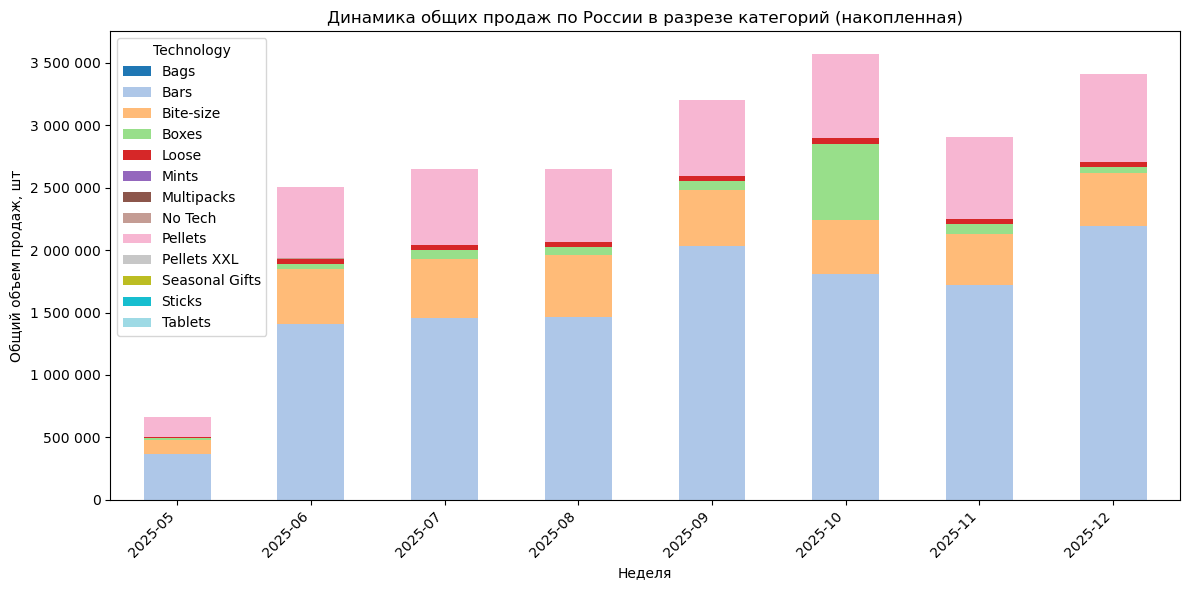

In [97]:
# Строим накопленную (stacked) столбчатую диаграмму
ax = pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'  # приятная палитра до 20 цветов
)

# Форматируем ось Y с разделением тысяч
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.title('Динамика общих продаж по России в разрезе категорий (накопленная)')
plt.xlabel('Неделя')
plt.ylabel('Общий объем продаж, шт')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [103]:
pivot_data_uraza_reg = uraza_regions.pivot_table(
    index='YearWeek',
    columns='Technology',
    values='Turnover Qty',
    aggfunc='sum',
    fill_value=0
)

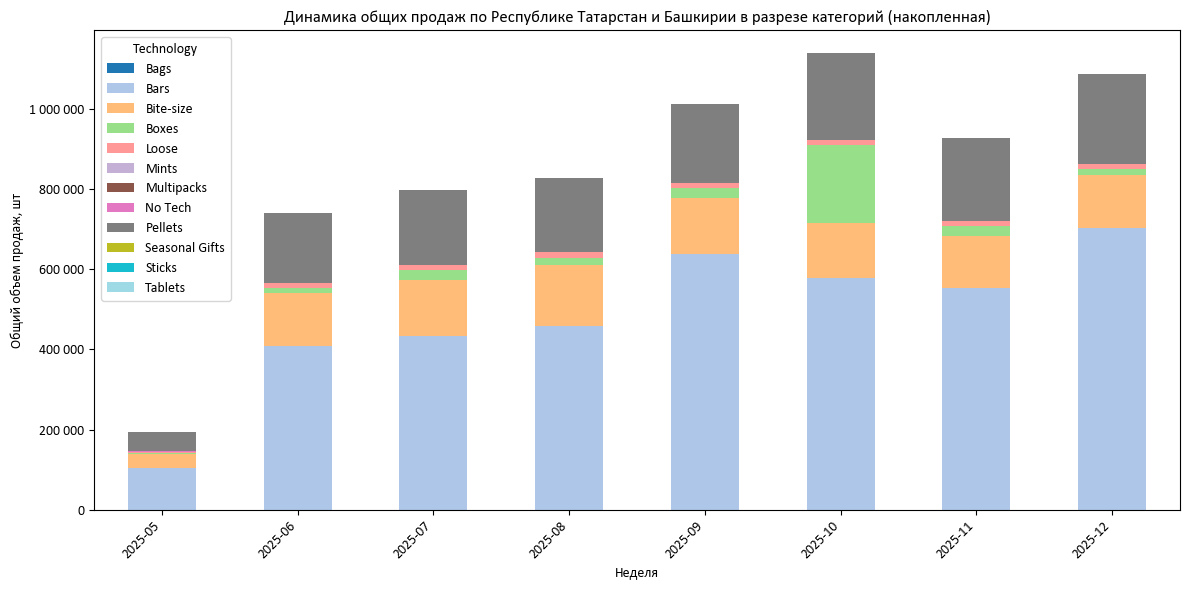

In [111]:
ax = pivot_data_uraza_reg.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))

plt.title('Динамика общих продаж по Республике Татарстан и Башкирии в разрезе категорий (накопленная)')
plt.xlabel('Неделя')
plt.ylabel('Общий объем продаж, шт')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [112]:
# Датасет с информацией только о республике Татарстан
tatar = uraza_regions.loc[uraza_regions['Outlet Region']=='Республика Татарстан (Татарстан)',]
tatar.shape

(456, 5)

In [113]:
# Датасет с информацией только о Башкирии
bashkir = uraza_regions.loc[uraza_regions['Outlet Region']=='Республика Башкортостан',]
bashkir.shape

(456, 5)

In [118]:
# Период праздника Ураза-байрам в републике Татарстан и Башкоторстан 
uraza_during=uraza_regions[((uraza_regions['YearWeek']=='2025-09')|(uraza_regions['YearWeek']=='2025-10')|(uraza_regions['YearWeek']=='2025-11')|(uraza_regions['YearWeek']=='2025-12'))]

In [119]:
# Период перед праздником Ураза-байрам в републике Татарстан и Башкоторстан 
uraza_before = uraza_regions[((uraza_regions['YearWeek']=='2025-05')|(uraza_regions['YearWeek']=='2025-06')|(uraza_regions['YearWeek']=='2025-07')|(uraza_regions['YearWeek']=='2025-08'))]

In [107]:
data_not_uraza_regions = data[(data['Outlet Region']!='Республика Татарстан (Татарстан)')|(data['Outlet Region']!='Республика Башкортостан')]
data_not_uraza_regions.shape

(5486, 5)

In [122]:
control_during = data_not_uraza_regions[((data_not_uraza_regions['YearWeek']=='2025-09')|(data_not_uraza_regions['YearWeek']=='2025-10')|(data_not_uraza_regions['YearWeek']=='2025-11')|(data_not_uraza_regions['YearWeek']=='2025-12'))]

In [123]:
control_before = data_not_uraza_regions[((data_not_uraza_regions['YearWeek']=='2025-05')|(data_not_uraza_regions['YearWeek']=='2025-06')|(data_not_uraza_regions['YearWeek']=='2025-07')|(data_not_uraza_regions['YearWeek']=='2025-08'))]

In [108]:
df = data.groupby(['YearWeek', 'Outlet Region'])['Turnover Qty'].mean().reset_index()

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Динамика продаж по регионам России')

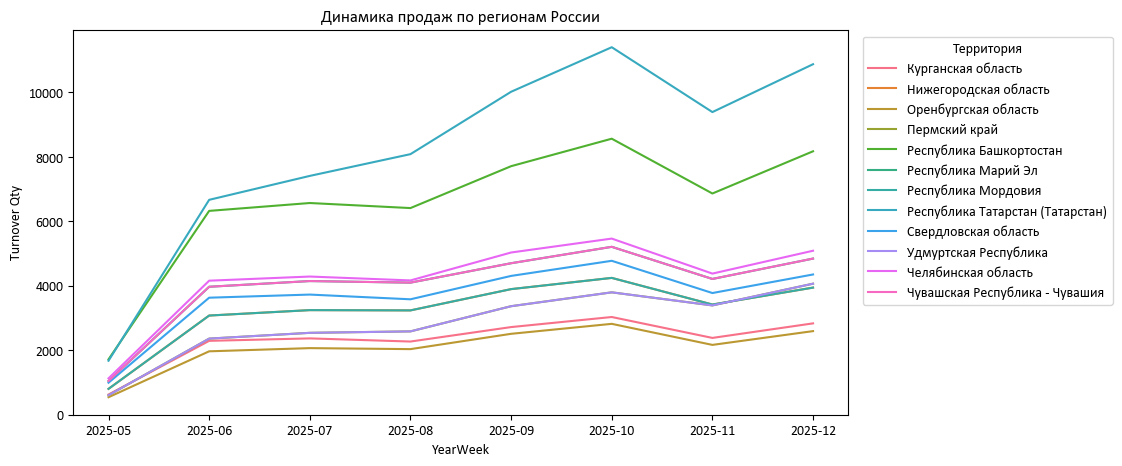

In [116]:
colors = ['#FFDA0E', '#8CBF3F', '#5653B0', '#268C5C', '#1FADBA', '#EBA808', '#AEADAD']

plt.rcParams['font.family'] = 'Calibri'  # Change 'serif' to your desired font (e.g., 'Times New Roman', 'Arial', etc.)
plt.rcParams['font.size'] = 10

# Plotting
plt.figure(figsize=(10, 5))
# Plot all regions except 'World'
ax = sns.lineplot(data=df, x='YearWeek', y='Turnover Qty', hue='Outlet Region')
ax.legend(title='Территория', loc='upper right', bbox_to_anchor=(1.35,1))

plt.title('Динамика продаж по регионам России')

C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Динамика продаж в республике Татарстан и Башкортостан')

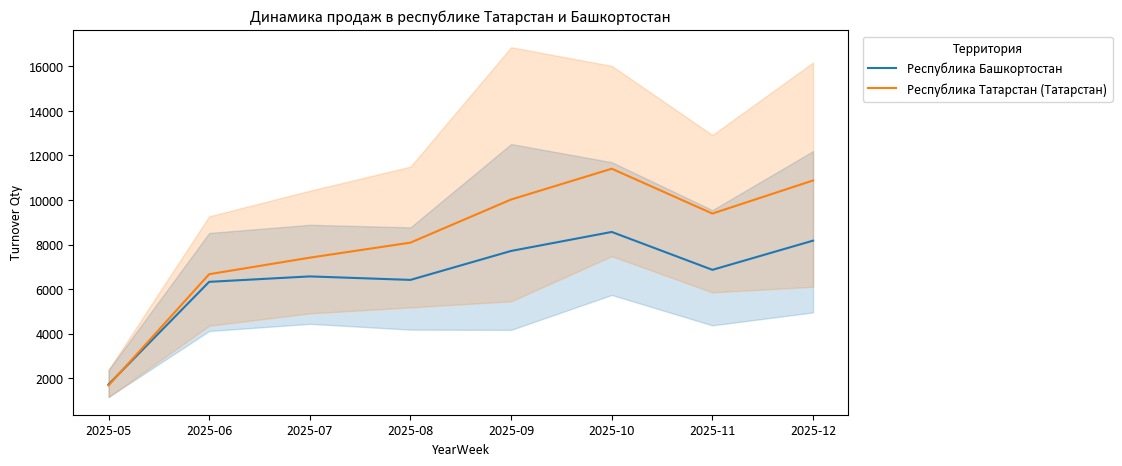

In [117]:
colors = ['#FFDA0E', '#8CBF3F', '#5653B0', '#268C5C', '#1FADBA', '#EBA808', '#AEADAD']

plt.rcParams['font.family'] = 'Calibri'  # Change 'serif' to your desired font (e.g., 'Times New Roman', 'Arial', etc.)
plt.rcParams['font.size'] = 10

# Plotting
plt.figure(figsize=(10, 5))
# Plot all regions except 'World'
ax = sns.lineplot(data=uraza_regions, x='YearWeek', y='Turnover Qty', hue='Outlet Region')

ax.legend(title='Территория', loc='upper right', bbox_to_anchor=(1.35,1))

plt.title('Динамика продаж в республике Татарстан и Башкортостан')

#### Вывод

- Республики Татарстан и Башкортостан в целом демонстрируют более высокие продажи по сравнению с другими регионами
- В период праздника Ураза-байрам демонстрируют существенный рост в продажах по сравнению с другими регионами
- Топ категорий товаров по продажам Bars, Pellets, BiteSize и Boxes
- Пик продаж достигнут в период праздника на 10 неделе - основной вкладчик в рост продаж категория Boxes

## Проверка гипотезы

- defore_uraza - данные по республике Татарстан и Башкоторстан до праздника
- uraza - данные по республике Татарстан и Башкоторстан во время праздника
---------------------------------------------------------------------------
- control_during - данные по остальным регионам во время праздника
- control_before - данные по остальным регионам до праздника

<Axes: >

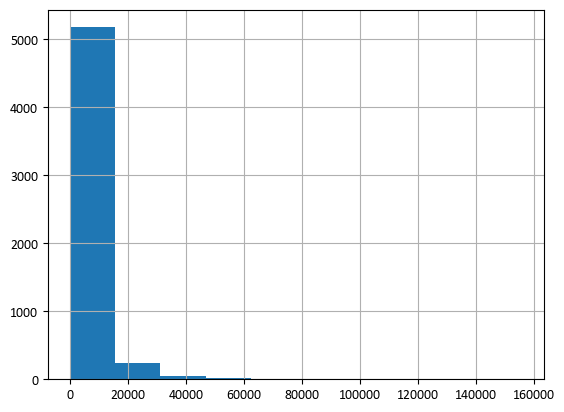

In [140]:
data['Turnover Qty'].hist()

In [143]:
before_uraza = before_uraza['Turnover Qty']

In [144]:
uraza = uraza['Turnover Qty']

In [145]:
control_during = control_during['Turnover Qty']

In [146]:
control_before = control_before['Turnover Qty']

### Bootstrap (Башкирия и Татрстан VS остальные регионы)

Чтобы учесть изменение продаж под влиянием сезонности и других факторов, сначала найдем разницу в тестовой (регионы Татарстан и Башкирия) и контрольной выборке (остальные регионы) до и после праздника. А затем посчитаем разницу между разницами вычисленными на предыдущем шаге.

In [141]:
def bootstrap_diff(group1_before, group1_after, group2_before, group2_after, n_iter=10000):
    np.random.seed(42)
    delta_list = []

    for _ in range(n_iter):
        sample1_before = np.random.choice(group1_before, size=len(group1_before), replace=True)
        sample1_after = np.random.choice(group1_after, size=len(group1_after), replace=True)
        sample2_before = np.random.choice(group2_before, size=len(group2_before), replace=True)
        sample2_after = np.random.choice(group2_after, size=len(group2_after), replace=True)

        delta1 = sample1_after.mean() - sample1_before.mean()
        delta2 = sample2_after.mean() - sample2_before.mean()

        delta_effect = delta1 - delta2
        delta_list.append(delta_effect)

    return delta_list

In [147]:
bootstrap_results = bootstrap_diff(before_uraza.values, uraza.values,
                                   control_before.values, control_during.values)


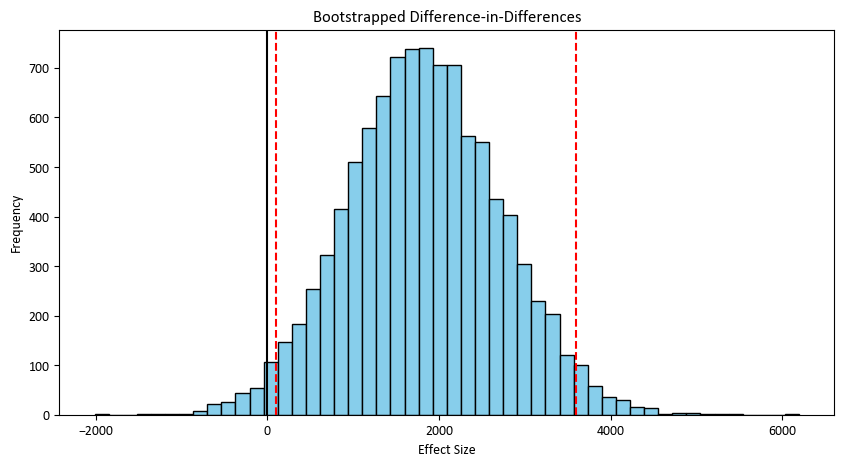

In [148]:
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_results, bins=50, color='skyblue', edgecolor='k')
plt.axvline(x=np.percentile(bootstrap_results, 2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bootstrap_results, 97.5), color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Bootstrapped Difference-in-Differences")
plt.xlabel("Effect Size")
plt.ylabel("Frequency")
plt.show()

In [149]:
ci_lower = np.percentile(bootstrap_results, 2.5)
ci_upper = np.percentile(bootstrap_results, 97.5)
mean_effect = np.mean(bootstrap_results)

In [150]:
print(f"Средний эффект: {mean_effect:.2f}")
print(f"95% доверительный интервал: [{ci_lower:.2f}, {ci_upper:.2f}]")

Средний эффект: 1823.09
95% доверительный интервал: [99.36, 3592.12]


In [151]:
if ci_lower > 0:
    print("✅ Рост в тестовой группе статистически значим.")
elif ci_upper < 0:
    print("🔻 Падение в тестовой группе статистически значимо.")
else:
    print("❔ Изменение не является статистически значимым.")

✅ Рост в тестовой группе статистически значим.
